# Replication of Deepmind's official CNPs implementation in Pytorch

## Points of interest

The following aspects of Deepmind's implementation stand out to me or differ from my implementation:
- Concatination treats x and y as two dimensions, appending along the "filter domain" (last dim/axis). This is important in this implementation because we are combing (flattening) all data points across the batches (merging these two dimensions into one). We thus still pass pairs into the encoder at the same time.
- GPU acceleration through parallelisation (if GPU available)
- Decoder: 
  - concating a 128-d vector and a 1-d vector feels a bit unbalanced in terms of informational encoding.
  - Variance clipping applied (0.1 + Softplus(log_sigma)) as recommended in [Le, Tuan Anh, et al. "Empirical evaluation of neural process objectives." NeurIPS workshop on Bayesian Deep Learning. Vol. 4. 2018.](http://bayesiandeeplearning.org/2018/papers/92.pdf)
- Only context passed through Encoder, never the target pairs.
- Objective:
  - Objective is purely the NLL.
- DataGenerator:
  - Kernel (SE) and kernel parameters (ls and variance) are fixed.

## To improve
- Encoder input_features currently hardcoded

## Resources

[Link to Deepmind's Google Colab](https://colab.research.google.com/github/deepmind/neural-processes/blob/master/conditional_neural_process.ipynb#scrollTo=SI188jyyJvHl)  
[Link to Deemind's repository https://github.com/deepmind/neural-processes](https://github.com/deepmind/neural-processes)

**Conditional Neural Processes**:   
Garnelo M, Rosenbaum D, Maddison CJ, Ramalho T, Saxton D, Shanahan M, Teh YW, Rezende DJ, Eslami SM. Conditional Neural Processes. In International Conference on Machine Learning 2018.

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import torch

## Data Generator

- Original Tensorflow (tf) commands are left in as comments.
- Creates GP curved with SE kernel
- lengthscale and output scale are fixed

In [154]:
# The CNP takes as input a `CNPRegressionDescription` namedtuple with fields:
#   `query`: a tuple containing ((context_x, context_y), target_x)
#   `target_y`: a tesor containing the ground truth for the targets to be
#     predicted
#   `num_total_points`: A vector containing a scalar that describes the total
#     number of datapoints used (context + target)
#   `num_context_points`: A vector containing a scalar that describes the number
#     of datapoints used as context
# The GPCurvesReader returns the newly sampled data in this format at each
# iteration

CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription",
    ("query", "target_y", "num_total_points", "num_context_points"))

class GPCurvesReader(object):
  """Generates curves using a Gaussian Process (GP).

  Supports vector inputs (x) and vector outputs (y). Kernel is
  mean-squared exponential, using the x-value l2 coordinate distance scaled by
  some factor chosen randomly in a range. Outputs are independent gaussian
  processes.
  """

  def __init__(self,
               batch_size,
               max_num_context,
               x_size = 1,
               y_size = 1,
               l1_scale = 0.4,
               sigma_scale = 1.0,
               testing = False):
    """Creates a regression dataset of functions sampled from a GP.

    Args:
      batch_size: An integer.
      max_num_context: The max number of observations in the context.
      x_size: Integer >= 1 for length of "x values" vector.
      y_size: Integer >= 1 for length of "y values" vector.
      l1_scale: Float; typical scale for kernel distance function.
      sigma_scale: Float; typical scale for variance.
      testing: Boolean that indicates whether we are testing. If so there are
          more targets for visualization.
    """
    self._batch_size = batch_size
    self._max_num_context = max_num_context
    self._x_size = x_size
    self._y_size = y_size
    self._l1_scale = l1_scale
    self._sigma_scale = sigma_scale
    self._testing = testing

  def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise = 2e-2):
    """Applies the Gaussian kernel to generate curve data.

    Args:
      xdata: Tensor with shape `[batch_size, num_total_points, x_size]` with
          the values of the x-axis data.
      l1: Tensor with shape `[batch_size, y_size, x_size]`, the scale
          parameter of the Gaussian kernel.
      sigma_f: Float tensor with shape `[batch_size, y_size]`; the magnitude
          of the std.
      sigma_noise: Float, std of the noise that we add for stability.

    Returns:
      The kernel, a float tensor with shape
      `[batch_size, y_size, num_total_points, num_total_points]`.
    """
    # Extract number of data points from tensor so this works for both testing and training
    num_total_points = xdata.shape[1]

    # Expand and take the difference
    xdata1 = xdata.unsqueeze(dim = 1) # [B, 1, num_total_points, x_size]
    xdata2 = xdata.unsqueeze(dim = 2) # [B, num_total_points, 1, x_size]

    # xdata1 = tf.expand_dims(xdata, axis=1)  # [B, 1, num_total_points, x_size]
    # xdata2 = tf.expand_dims(xdata, axis=2)  # [B, num_total_points, 1, x_size]
    diff = xdata1 - xdata2  # [B, num_total_points, num_total_points, x_size]

    # Insert dimension for y_size: [B, y_size, num_total_points, num_total_points, x_size]
    # same as diff[:, None, :, :, :]
    diff_expanded = diff.unsqueeze(dim = 1)

    # Scale the differences (lengthscale) and square
    # l1[:, :, None, None, :] created explicit dimensions to that dimensionality matches
    norm = torch.square(diff_expanded / l1[:, :, None, None, :])
    # Norm has shape [B, y_size, num_total_points, num_total_points, x_size]

    # norm = tf.square(diff[:, None, :, :, :] / l1[:, :, None, None, :])

    # Sum along last dimension (x_size) to reduce this dimension
    norm = torch.sum(norm, dim = -1)
    # Norm now has shape [B, y_size, num_total_points, num_total_points]

    # norm = tf.reduce_sum(norm, -1)  # [B, data_size, num_total_points, num_total_points]

    kernel = torch.square(sigma_f)[:, :, None, None] * torch.exp(-0.5 * norm)
    # kernel = tf.square(sigma_f)[:, :, None, None] * tf.exp(-0.5 * norm)
    # Kernel has shape [B, y_size, num_total_points, num_total_points]

    # Add some noise to the diagonal to make the cholesky work.
    # sigma_noise.pow(2) = sigma_noise ** 2
    kernel = kernel + ((sigma_noise ** 2) * torch.eye(n = num_total_points))
    # kernel += (sigma_noise**2) * tf.eye(num_total_points)

    return kernel

  def generate_curves(self):
    """Builds the op delivering the data.

    Generated functions are `float32` with x values between -2 and 2.
    
    Returns:
      A `CNPRegressionDescription` namedtuple.
    """
    # Sample number of context points between 3 and max_num_content
    # Torch: low (inclusive) and high (exclusive)
    num_context = torch.randint(low = 3, high = self._max_num_context, size = (1,))
    # num_context = tf.random_uniform(shape = [], minval = 3, maxval = self._max_num_context, dtype = tf.int32)

    ### X-VALUES ###
    # If we are TESTING we want to have more targets and have them evenly distributed in order to plot the function.
    if self._testing:
      num_target = 400
      num_total_points = num_target
      # tf.expand_dims or torch.unsqueeze add dimension of length one
      # torch.tile create x batch replicas
      x_values = torch.tile(input = torch.arange(start = -2., end = 2., step = 1./100).unsqueeze(dim = 0),
                 dims = (self._batch_size, 1))
     
      # Add explicit last dimension
      x_values = x_values.unsqueeze(dim = -1)
      # x_value has shape (batch_size, num_target, x_size)

      # x_values = tf.tile(tf.expand_dims(tf.range(-2., 2. , 1. / 100, dtype = tf.float32), axis = 0),[self._batch_size, 1])
      # x_values = tf.expand_dims(x_values, axis=-1)

    # During TRAINING the number of target points and their x-positions are selected at random
    # Since x_value samples have no order, the kernel looks funky
    else:
      num_target = torch.randint(low = 2, high = self._max_num_context, size = (1,))
      # num_target = tf.random_uniform(shape = (), minval = 2, maxval = self._max_num_context, dtype = tf.int32)
      num_total_points = num_context + num_target
      # sample unformly between [0, 1), then scale and shift
      x_values = ((torch.rand(size = (self._batch_size, num_total_points, self._x_size)) * 4) - 2)
      # x_values = tf.random_uniform([self._batch_size, num_total_points, self._x_size], -2, 2)

    ### Y-VALUES ###
    # Set kernel parameters
    # Copy l1_scale and sigma_f into the right shaped tensors
    l1 = torch.ones(size = (self._batch_size, self._y_size, self._x_size)) * self._l1_scale
    sigma_f = torch.ones(size = (self._batch_size, self._y_size)) * self._sigma_scale

    # l1 = (tf.ones(shape = [self._batch_size, self._y_size, self._x_size]) * self._l1_scale)
    # sigma_f = tf.ones(shape = [self._batch_size, self._y_size]) * self._sigma_scale

    ### GAUSSIAN KERNEL ###
    # Pass the x_values through the Gaussian kernel
    # [batch_size, y_size, num_total_points, num_total_points]
    kernel = self._gaussian_kernel(x_values, l1, sigma_f)

    # Computes the Cholesky decomposition for batches of symmetric positive-definite matrices
    cholesky = torch.linalg.cholesky(kernel)
    # cholesky has shape [batch_size, y_size, num_total_points, num_total_points]

    # Calculate Cholesky, using double precision for better stability:
    # cholesky = tf.cast(tf.cholesky(tf.cast(kernel, tf.float64)), tf.float32)

    # Sample a curve: randn stand for random normal
    y_values = torch.matmul(cholesky, torch.randn(size = (self._batch_size, self._y_size, num_total_points, 1)))
    # y_values has shape [batch_size, y_size, num_total_points, 1]

    # y_values = tf.matmul(cholesky, tf.random_normal([self._batch_size, self._y_size, num_total_points, 1]))

    # Squeeze last dimension and transpose last two dimensions
    y_values = torch.transpose(input = y_values.squeeze(dim = -1), dim0 = 2, dim1 = 1)
    # y_values now has shape [batch_size, num_total_points, y_size]
    
    # y_values = tf.transpose(tf.squeeze(y_values, 3), [0, 2, 1])

    if self._testing:
      # Select the targets
      target_x = x_values
      target_y = y_values

      # Select the observations (num_context subset of target)
      # Returns a random permutation of integers from 0 to n - 1.
      idx = torch.randperm(n = int(num_target))
      # idx = tf.random_shuffle(tf.range(num_target))

      # Subset first "num_context" points from dim 1 into the context
      context_x = x_values[:, idx[:num_context], :]
      context_y = y_values[:, idx[:num_context], :]

      # context_x = tf.gather(x_values, idx[:num_context], axis=1)
      # context_y = tf.gather(y_values, idx[:num_context], axis=1)

    else:
      # Select the targets which will consist of the context points as well as some new target points
      # same as target_x = x_values (all values)
      target_x = x_values[:, :num_target + num_context, :]
      target_y = y_values[:, :num_target + num_context, :]

      # Select the observations
      context_x = x_values[:, :num_context, :]
      context_y = y_values[:, :num_context, :]

    query = ((context_x, context_y), target_x)

    return CNPRegressionDescription(
        query = query,
        target_y = target_y,
        num_total_points = target_x.shape[1],
        # num_total_points=tf.shape(target_x)[1],
        num_context_points = num_context)

### Resulting sizes of samples:
- num_contexts: integer samples uniformly at random from [3, 10) (3 included, 10 excluded)
- num_targets: 
  - TESTING: 400
  - TRAINING: sampled between [2, 10) (10: max_num_content, same limit)
- num_total
  - TESTING: 400 
  - TRAINING: [5, 18]

### DataGenerator code hierarchy:
class GPCurvesReader(object):  
- def _gaussian_kernel():  
- def generate_curves(self):  
    - calls _gaussian_kernel()  


## Encoder

The encoder **e** is shared between all the context points and consists of an
MLP with a handful of layers. For this experiment four layers are enough, but we
can still change the number and size of the layers when we build the graph later
on via the variable **`encoder_output_sizes`**. Each of the context pairs **(x,
y)<sub>i</sub>** results in an individual representation **r<sub>i</sub>** after
encoding. These representations are then combined across context points to form
a single representation **r** using the aggregator **a**.

In this implementation we have included the aggregator **a** in the encoder as
we are only taking the mean across all points. The representation **r** produced
by the aggregator contains the information about the underlying unknown function
**f** that is provided by all the context points.

In [155]:
from torch import nn

class DeterministicEncoder(nn.Module):
# class DeterministicEncoder(object):
  """The Encoder."""

  def __init__(self, output_sizes):
    """CNP encoder. Encoding 2-d (pairs of x-y) into the 128ßd dimensional space.

    Args:
      output_sizes: A list (iterable) containing the output sizes of the encoding MLP.
    """
    super().__init__()
    self._output_sizes = output_sizes

    # PyTorch: need to initiate layers in __init__ not forward()
    # First layer - Warning: HARDCODE 2
    self.module_list = nn.ModuleList([nn.Linear(in_features = 2, out_features = self._output_sizes[0])])
    # Activate
    self.module_list.append(nn.ReLU(inplace = True))

    # Add as many layers as needed
    for i, size in enumerate(self._output_sizes[1 : -1]):
      # i: previous index since we start at 1 
      self.module_list.append(nn.Linear(in_features = self._output_sizes[i], out_features = self._output_sizes[i + 1]))
      self.module_list.append(nn.ReLU(inplace = True))

    # Last layer without activation
    self.module_list.append(nn.Linear(in_features = self._output_sizes[-2], out_features = self._output_sizes[-1]))

  def forward(self, context_x, context_y, num_context_points):
    """Encodes the inputs into one representation.

    Args:
      context_x: Tensor of size bs x observations x m_ch. For this 1D regression
          task this corresponds to the x-values.
      context_y: Tensor of size bs x observations x d_ch. For this 1D regression
          task this corresponds to the y-values.
      num_context_points: A tensor containing a single scalar that indicates the
          number of context_points provided in this iteration.

    Returns:
      representation: The encoded representation averaged over all context 
          points.
    """
    # Concatenate x and y along the filter axes
    # DIFFERS from other implementation which concats along dim = 1
    encoder_input = torch.cat((context_x, context_y), dim = -1)
    # encoder_input = tf.concat([context_x, context_y], axis = -1)

    # Get the shapes of the input and reshape to parallelise across observations & batches
    batch_size, _ , filter_size = encoder_input.shape
    # batch_size, _ , filter_size = encoder_input.shape.as_list()

    # Combine dim batches to improve parallelisation
    hidden = torch.reshape(input = encoder_input, shape = (batch_size * num_context_points, -1))
    # hidden = tf.reshape(encoder_input, (batch_size * num_context_points, -1))
    # Redundant:
    # hidden.set_shape((None, filter_size))

    # FORWARD
    for module in self.module_list:
            hidden = module(hidden)

    # # Pass through MLP
    # with tf.variable_scope("encoder", reuse=tf.AUTO_REUSE):
    #  for i, size in enumerate(self._output_sizes[:-1]):
    #    hidden = tf.nn.relu(
    #       tf.layers.dense(hidden, size, name="Encoder_layer_{}".format(i)))

    #  # Last layer without a ReLu
    #  hidden = tf.layers.dense(
    #      hidden, self._output_sizes[-1], name = "Encoder_layer_{}".format(i + 1))

    # Bring back into original shape
    hidden = torch.reshape(input = hidden, shape = (batch_size, num_context_points, self._output_sizes[-1]))
    # hidden = tf.reshape(hidden, (batch_size, num_context_points, size))

    # Aggregator: take the mean over all points (dim 1). One represntation per batch.
    representation = torch.mean(input = hidden, dim = 1)
    # representation = tf.reduce_mean(hidden, axis=1)

    return representation

## Decoder

Once we have obtained our representation **r** we concatenate it with each of
the targets **x<sub>t</sub>** and pass it through the decoder **d**. As with the
encoder **e**, the decoder **d** is shared between all the target points and
consists of a small MLP with layer sizes defined in **`decoder_output_sizes`**.
The decoder outputs a mean **&mu;<sub>t</sub>** and a variance
**&sigma;<sub>t</sub>** for each of the targets **x<sub>t</sub>**. To train our
CNP we use the log likelihood of the ground truth value **y<sub>t</sub>** under
a Gaussian parametrized by these predicted **&mu;<sub>t</sub>** and
**&sigma;<sub>t</sub>**.

In this implementation we clip the variance **&sigma;<sub>t</sub>** at 0.1 to
avoid collapsing.

In [156]:
from torch.nn import functional as F # SoftPlus
from torch.distributions import Normal

class DeterministicDecoder(nn.Module):
  """The Decoder."""

  def __init__(self, output_sizes):
    """CNP decoder.

    Args:
      output_sizes: A list (iterable) containing the output sizes of the decoder MLP.
    """
    super().__init__()
    self._output_sizes = output_sizes

    # PyTorch: need to initiate layers in __init__ not forward()
    # First layer - HARDCODE 128 + 1 for x_dim
    self.module_list = nn.ModuleList([nn.Linear(in_features = self._output_sizes[0] + 1, out_features = self._output_sizes[0])])
    # activate
    self.module_list.append(nn.ReLU(inplace = True))

    for i, size in enumerate(self._output_sizes[1 : -1]):
      # i: previous layer (we start with 1)
      self.module_list.append(nn.Linear(in_features = self._output_sizes[i], out_features = self._output_sizes[i + 1]))
      self.module_list.append(nn.ReLU(inplace = True))

    # Last layer without activation (Output size is 2: mean and sigma)
    self.module_list.append(nn.Linear(in_features = self._output_sizes[-2], out_features = self._output_sizes[-1]))

  def forward(self, representation, target_x, num_total_points):
  # def __call__(self, representation, target_x, num_total_points):
    """Decodes the individual targets.

    Args:
      representation: The encoded representation of the context
      target_x: The x locations for the target query
      num_total_points: The number of target points.

    Returns:
      dist: A multivariate Gaussian over the target points.
      mu: The mean of the multivariate Gaussian.
      sigma: The standard deviation of the multivariate Gaussian.
    """

    # Concatenate the representation and the target_x along the last dim

    # Keep number of batches but creates a copy for every data point
    representation = torch.tile(input = representation.unsqueeze(dim = 1), dims = (1, num_total_points, 1))
    # representation = tf.tile(tf.expand_dims(representation, axis=1), [1, num_total_points, 1])

    # concat along last dim
    input = torch.concat((representation, target_x), dim = -1)
    # input = tf.concat([representation, target_x], axis=-1)

    # Get the shapes of the input and reshape to parallelise across observations
    batch_size, _ , filter_size = input.shape
    # batch_size, _, filter_size = input.shape.as_list()

    hidden = torch.reshape(input = input, shape = (batch_size * num_total_points, -1))
    # hidden = tf.reshape(input, (batch_size * num_total_points, -1))
    # hidden.set_shape((None, filter_size))

    # FORWARD
    for module in self.module_list: 
      hidden = module(hidden)

    # Pass through MLP
    # with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
    #  for i, size in enumerate(self._output_sizes[:-1]):
    #    hidden = tf.nn.relu(
    #        tf.layers.dense(hidden, size, name="Decoder_layer_{}".format(i)))

    #  # Last layer without a ReLu
    #  hidden = tf.layers.dense(
    #      hidden, self._output_sizes[-1], name="Decoder_layer_{}".format(i + 1))

    # Bring back into original shape
    hidden = torch.reshape(input = hidden, shape = (batch_size, num_total_points, -1))
    # hidden = tf.reshape(hidden, (batch_size, num_total_points, -1))

    # Get the mean an the variance by splitting the last dimension in two
    mu, log_sigma = torch.split(tensor = hidden, split_size_or_sections = (1, 1), dim = -1)
    # mu, log_sigma = tf.split(hidden, 2, axis=-1)

    # Variance clipping
    sigma = 0.1 + 0.9 * F.softplus(log_sigma)
    # sigma = 0.1 + 0.9 * tf.nn.softplus(log_sigma)

    # Get the distribution
    dist = Normal(mu, sigma)
    # dist = tf.contrib.distributions.MultivariateNormalDiag(loc = mu, scale_diag = sigma)

    # Return distribution object and mean and variance parameters
    return dist, mu, sigma

## Model

Now that the main building blocks (encoder, (aggregator) and decoder) of the CNP
are defined we can put everything together into one model. Fundamentally this
model only needs to include two main methods: 1. A method that returns the log
likelihood of the targets' ground truth values under the predicted
distribution.This method will be called during training as our loss function. 2.
Another method that returns the predicted mean and variance at the target
locations in order to evaluate or query the CNP at test time. This second method
needs to be defined separately as, unlike the method above, it should not depend
on the ground truth target values.

In [157]:
class DeterministicModel(nn.Module):
  """The CNP model."""

  def __init__(self, encoder_output_sizes, decoder_output_sizes):
    """Initialises the model.

    Args:
      encoder_output_sizes: An iterable containing the sizes of hidden layers of
          the encoder. The last one is the size of the representation r.
      decoder_output_sizes: An iterable containing the sizes of hidden layers of
          the decoder. The last element should correspond to the dimension of
          the y * 2 (it encodes both mean and variance concatenated)
    """
    super().__init__()
    # Inittialise Encoder and Decoder
    self._encoder = DeterministicEncoder(encoder_output_sizes)
    self._decoder = DeterministicDecoder(decoder_output_sizes)
  
  def forward(self, query, num_total_points, num_contexts, target_y = None):
  # def __call__(self, query, num_total_points, num_contexts, target_y = None):
    """Returns the predicted mean and variance at the target points.

    Args:
      query: Array containing ((context_x, context_y), target_x) where:
          context_x: Array of shape batch_size x num_context x 1 contains the 
              x values of the context points.
          context_y: Array of shape batch_size x num_context x 1 contains the 
              y values of the context points.
          target_x: Array of shape batch_size x num_target x 1 contains the
              x values of the target points.
      target_y: The ground truth y values of the target y. An array of 
          shape batchsize x num_targets x 1.
      num_total_points: Number of target points.

    Returns:
      log_p: The log_probability of the target_y given the predicted
      distribution.
      mu: The mean of the predicted distribution.
      sigma: The variance of the predicted distribution.
    """
    # Unpack query
    (context_x, context_y), target_x = query

    # Pass query through the encoder and the decoder
    # Only context passed through encoder
    representation = self._encoder(context_x, context_y, num_contexts)
    dist, mu, sigma = self._decoder(representation, target_x, num_total_points)

    # If we want to calculate the log_prob for training we will make use of the target_y. 
    # At test time the target_y is not available so we return None
    if target_y is not None:
      log_p = dist.log_prob(target_y)
    else:
      log_p = None

    return log_p, mu, sigma

## Running Conditional Neural Processes

Now that we have defined the dataset as well as our model and its components we
can start building everything into the graph. Before we get started we need to
set some variables:

*   **`TRAINING_ITERATIONS`** - a scalar that describes the number of iterations
    for training. At each iteration we will sample a new batch of functions from
    the GP, pick some of the points on the curves as our context points **(x,
    y)<sub>C</sub>** and some points as our target points **(x,
    y)<sub>T</sub>**. We will predict the mean and variance at the target points
    given the context and use the log likelihood of the ground truth targets as
    our loss to update the model.
*   **`MAX_CONTEXT_POINTS`** - a scalar that sets the maximum number of contest
    points used during training. The number of context points will then be a
    value between 3 and `MAX_CONTEXT_POINTS` that is sampled at random for every
    iteration.
*   **`PLOT_AFTER`** - a scalar that regulates how often we plot the
    intermediate results.

In [158]:
TRAINING_ITERATIONS = int(2e5)
MAX_CONTEXT_POINTS = 10
PLOT_AFTER = int(2e4)
# tf.reset_default_graph()

print(f"Training iterations: {TRAINING_ITERATIONS}")
print(f"Maximum context points: {MAX_CONTEXT_POINTS}")
print(f"Plot after: {PLOT_AFTER}") # results in 10 plots

Training iterations: 200000
Maximum context points: 10
Plot after: 20000


## Visualise Test data

In [2]:
# Train dataset
dataset_train = GPCurvesReader(batch_size = 64, max_num_context = MAX_CONTEXT_POINTS, testing = False)
data_train = dataset_train.generate_curves()

# Test dataset
dataset_test = GPCurvesReader(batch_size = 1, max_num_context = MAX_CONTEXT_POINTS, testing = True)
data_test = dataset_test.generate_curves()

# Extract training data
#((context_x, context_y), target_x), target_y, num_total_points, num_context_points = data_train
# Extract testing data (for visualisation)
((context_x, context_y), target_x), target_y, num_total_points, num_context_points = data_test
#((context_x, context_y), target_x), target_y, num_total_points, num_context_points = data_train

# Concat differences
# print(torch.cat((context_x, context_y), dim = -1).shape)
# print(torch.cat((context_x, context_y), dim = 1).shape)

NameError: name 'GPCurvesReader' is not defined

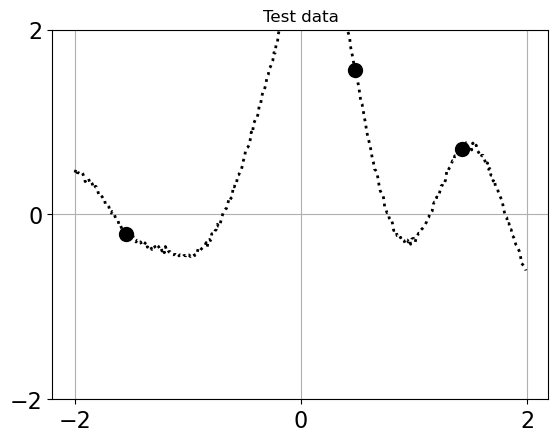

In [160]:
def plot_target_data(target_x, target_y, context_x, context_y):
  """Plots the one instantiation from the test dataset (batchsize 1) including target and context
  
  Args: 
    target_x: An array of shape batchsize x number_targets x 1 that contains the
        x values of the target points.
    target_y: An array of shape batchsize x number_targets x 1 that contains the
        y values of the target points.
    context_x: An array of shape batchsize x number_context x 1 that contains 
        the x values of the context points.
    context_y: An array of shape batchsize x number_context x 1 that contains 
        the y values of the context points.
  """
  # Plot everything
  plt.plot(target_x[0], target_y[0], 'k:', linewidth = 2)
  plt.plot(context_x[0], context_y[0], 'ko', markersize = 10)

  # Make the plot pretty
  plt.yticks([-2, 0, 2], fontsize = 16)
  plt.xticks([-2, 0, 2], fontsize = 16)
  plt.ylim([-2, 2])
  plt.grid('off')
  ax = plt.gca()
  ax.set_facecolor('white')
  # old: ax.set_axis_bgcolor('white')
  plt.title("Test data")
  plt.show()

plot_target_data(target_x, target_y, context_x, context_y)

## Plotting function

In [182]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, var):
  """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape batchsize x number_targets x 1 that contains the
        x values of the target points.
    target_y: An array of shape batchsize x number_targets x 1 that contains the
        y values of the target points.
    context_x: An array of shape batchsize x number_context x 1 that contains 
        the x values of the context points.
    context_y: An array of shape batchsize x number_context x 1 that contains 
        the y values of the context points.
    pred_y: An array of shape batchsize x number_targets x 1  that contains the
        predicted means of the y values at the target points in target_x.
    pred_y: An array of shape batchsize x number_targets x 1  that contains the
        predicted variance of the y values at the target points in target_x.
  """
  # Plot everything
  plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
  plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
  plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
  plt.fill_between(
      target_x[0, :, 0],
      pred_y[0, :, 0] - var[0, :, 0],
      pred_y[0, :, 0] + var[0, :, 0],
      alpha=0.2,
      facecolor='#65c9f7',
      interpolate=True)

  # Make the plot pretty
  plt.yticks([-2, 0, 2], fontsize=16)
  plt.xticks([-2, 0, 2], fontsize=16)
  plt.ylim([-2, 2])
  plt.grid('off')
  # ax = plt.gca()
  # ax.set_facecolor('white')
  # old: ax.set_axis_bgcolor('white')
  plt.show()

## Pytorch training loop

In [185]:
# Sizes of the layers of the MLPs for the encoder and decoder
# The final output layer of the decoder outputs two values, one for the mean and one for the variance of the prediction at the target location
encoder_output_sizes = [128, 128, 128, 128]
decoder_output_sizes = [128, 128, 2]

# Initialise the model
model = DeterministicModel(encoder_output_sizes, decoder_output_sizes)

# Initialise the optimiser
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4) # 0.0001

Iteration: 0, batch NLL loss (smaller is better): 1.4703657627105713


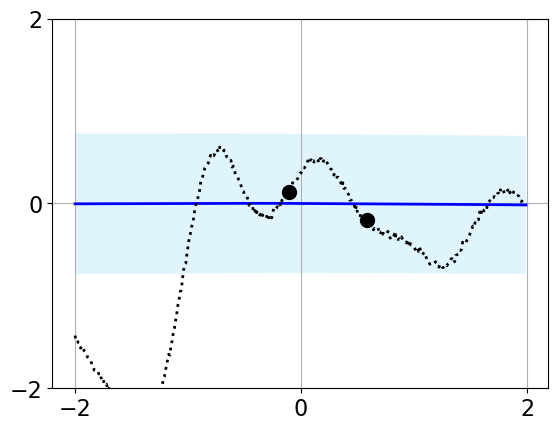

Iteration: 20000, batch NLL loss (smaller is better): 0.45535513758659363


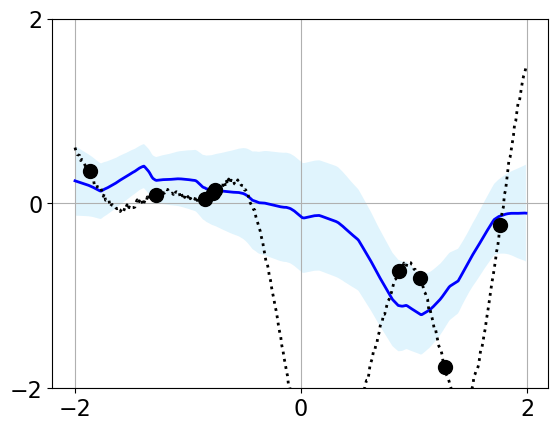

Iteration: 40000, batch NLL loss (smaller is better): 0.5679205656051636


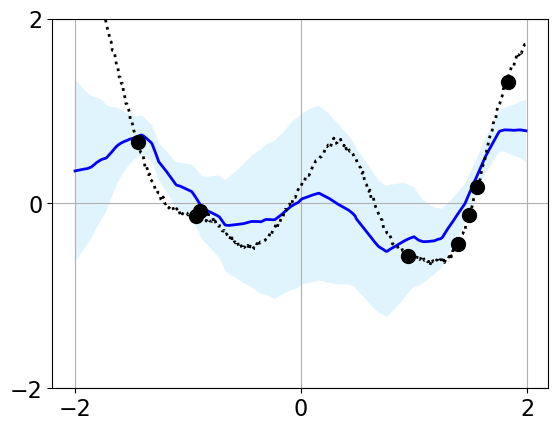

Iteration: 60000, batch NLL loss (smaller is better): 0.4351252615451813


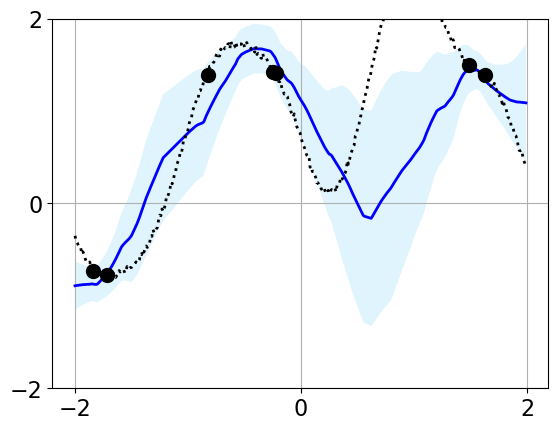

Iteration: 80000, batch NLL loss (smaller is better): 0.6641045808792114


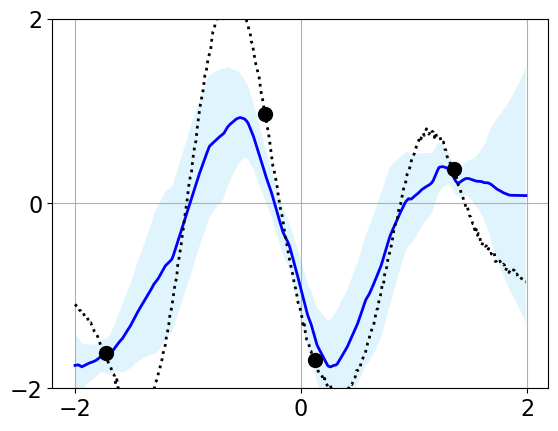

Iteration: 100000, batch NLL loss (smaller is better): 0.10174662619829178


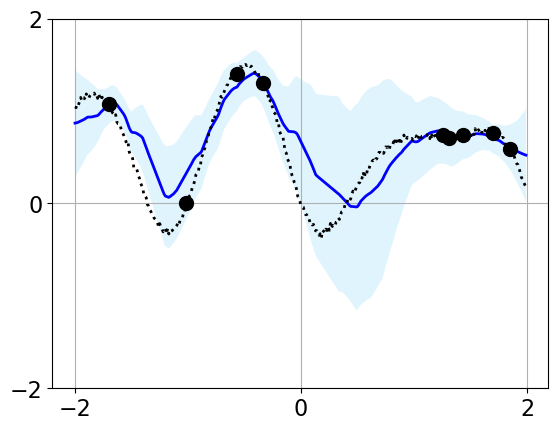

Iteration: 120000, batch NLL loss (smaller is better): 0.14133301377296448


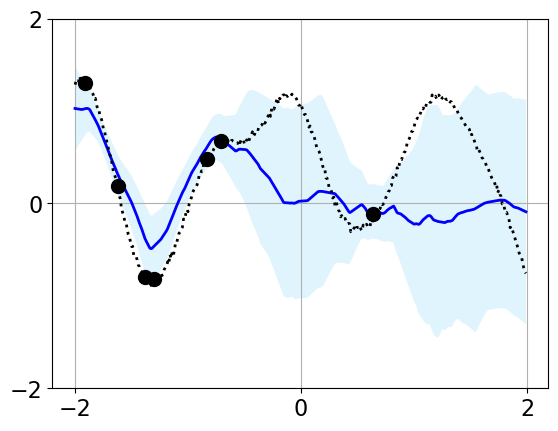

Iteration: 140000, batch NLL loss (smaller is better): 0.05265887826681137


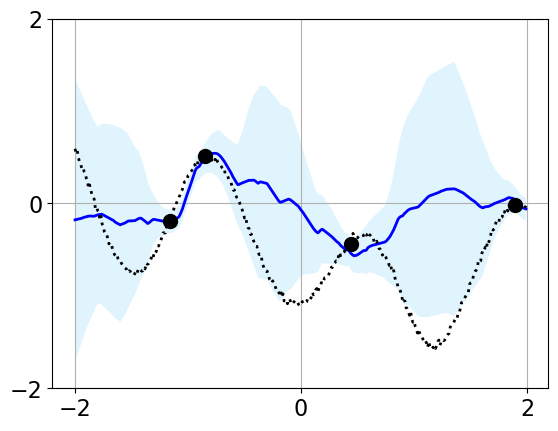

Iteration: 160000, batch NLL loss (smaller is better): 0.05192999169230461


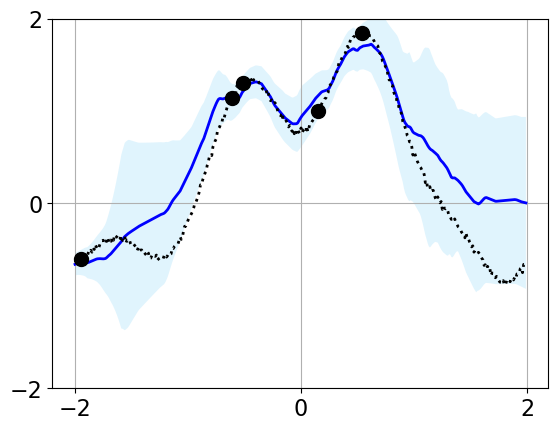

Iteration: 180000, batch NLL loss (smaller is better): 0.17126819491386414


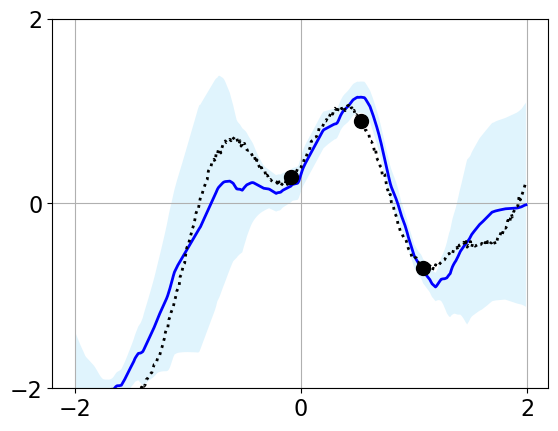

In [188]:
# Because we don't have a predefined dataset, we have iterations rather than epochs

loss_list = []

for it in range(TRAINING_ITERATIONS):

    # zero_grad?
    optimizer.zero_grad()
    model.train(True)

    # Create batch of TRAINING data
    dataset_train = GPCurvesReader(batch_size = 64, max_num_context = MAX_CONTEXT_POINTS, testing = False)
    data_train = dataset_train.generate_curves()

    # Pass a batch of training data through model
    log_prob, _ , _ = model(data_train.query, data_train.num_total_points, data_train.num_context_points, data_train.target_y)

    # NLL loss across all targets in batch
    loss = - log_prob.mean()
    loss_list.append(loss)
    loss.backward()
    optimizer.step()

    if it % PLOT_AFTER == 0:
        print('Iteration: {}, batch NLL loss (smaller is better): {}'.format(it, loss))

        # Generate TEST data
        dataset_test = GPCurvesReader(batch_size = 1, max_num_context = MAX_CONTEXT_POINTS, testing = True)
        data_test = dataset_test.generate_curves()
        # Unpack for plotting
        ((context_x, context_y), target_x), target_y, _, _ = data_test
        
        # Pass TEST data through model
        model.eval()
        _, mu, sigma = model(data_test.query, data_test.num_total_points, data_test.num_context_points)

        # plot_functions(target_x, target_y, context_x, context_y, mu.detach().numpy(), sigma.detach().numpy())
        plot_functions(target_x, target_y, context_x, context_y, mu.detach().numpy(), sigma.detach().numpy())

Without GPU this takes about 3:00 minutes per 20,000 iterations (`PLOT_AFTER`).  
Each iteration contains a batch of 64 context-target sets.  
Expected to underfit.

In [189]:
# Tensorflow code

""" # Sizes of the layers of the MLPs for the encoder and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
encoder_output_sizes = [128, 128, 128, 128]
decoder_output_sizes = [128, 128, 2]

# Define the model
model = DeterministicModel(encoder_output_sizes, decoder_output_sizes)

# Define the loss
log_prob, _, _ = model(data_train.query, data_train.num_total_points,
                       data_train.num_context_points, data_train.target_y)
loss = -tf.reduce_mean(log_prob)

# Get the predicted mean and variance at the target points for the testing set
_, mu, sigma = model(data_test.query, data_test.num_total_points,
                     data_test.num_context_points)

# Set up the optimizer and train step
optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)

# KB: is this like setting gradients to zero?
init = tf.initialize_all_variables() """

' # Sizes of the layers of the MLPs for the encoder and decoder\n# The final output layer of the decoder outputs two values, one for the mean and\n# one for the variance of the prediction at the target location\nencoder_output_sizes = [128, 128, 128, 128]\ndecoder_output_sizes = [128, 128, 2]\n\n# Define the model\nmodel = DeterministicModel(encoder_output_sizes, decoder_output_sizes)\n\n# Define the loss\nlog_prob, _, _ = model(data_train.query, data_train.num_total_points,\n                       data_train.num_context_points, data_train.target_y)\nloss = -tf.reduce_mean(log_prob)\n\n# Get the predicted mean and variance at the target points for the testing set\n_, mu, sigma = model(data_test.query, data_test.num_total_points,\n                     data_test.num_context_points)\n\n# Set up the optimizer and train step\noptimizer = tf.train.AdamOptimizer(1e-4)\ntrain_step = optimizer.minimize(loss)\n\n# KB: is this like setting gradients to zero?\ninit = tf.initialize_all_variables() 

In [146]:
# Tensorflow code

""" with tf.Session() as sess:
  sess.run(init)

  for it in range(TRAINING_ITERATIONS):
    sess.run([train_step])

    # Plot the predictions in `PLOT_AFTER` intervals
    if it % PLOT_AFTER == 0:
      loss_value, pred_y, var, target_y, whole_query = sess.run(
          [loss, mu, sigma, data_test.target_y, data_test.query])

      (context_x, context_y), target_x = whole_query
      print('Iteration: {}, loss: {}'.format(it, loss_value))

      # Plot the prediction and the context
      plot_functions(target_x, target_y, context_x, context_y, pred_y, var)"""

" with tf.Session() as sess:\n  sess.run(init)\n\n  for it in range(TRAINING_ITERATIONS):\n    sess.run([train_step])\n\n    # Plot the predictions in `PLOT_AFTER` intervals\n    if it % PLOT_AFTER == 0:\n      loss_value, pred_y, var, target_y, whole_query = sess.run(\n          [loss, mu, sigma, data_test.target_y, data_test.query])\n\n      (context_x, context_y), target_x = whole_query\n      print('Iteration: {}, loss: {}'.format(it, loss_value))\n\n      # Plot the prediction and the context\n      plot_functions(target_x, target_y, context_x, context_y, pred_y, var) "